<a href="https://colab.research.google.com/github/Murakami-Shoya/2021_school/blob/master/2_2021_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import glob, random
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# パスは変更のこと
path = "/content/drive/MyDrive/leap_dataset/hand_data_2021_100/"

## set_data関数：データをすべてまとめる

In [ ]:
def set_data(gesture_name):

    random.seed(123)

    # 1ジェスチャーが何フレームかでデータをスライスする量が変わる
    frame_num = 50

    output_df = pd.DataFrame()

    all_files = glob.glob(path + gesture_name + "*.csv")
    # ランダムに並べ替える
    shuffled_all_files = random.sample(all_files, len(all_files))

    for one_file in all_files:
        one_df = pd.read_csv(one_file, sep=',')[:frame_num]
        output_df = pd.concat([output_df, one_df])

    # output_df.to_csv("./all_data_folder/all_cut_data.csv",header=False,  index=False)
    return output_df

### 手のひら座標に変換する関数


引数はndarray
返り値もndarray

In [ ]:
def normalize(X):
            
    hands = X.reshape([-1, 27, 3])
    joints = []

    for hand in hands:
        palm_position = hand[0]
        direction = hand[1]
        palm_y = hand[2]
    
        palm_x = np.cross(direction, palm_y,)

        R = np.stack([palm_x, palm_y, direction])
        R = np.linalg.inv(R)

        joint = hand[3:]
        joint = joint - palm_position

        joint = np.dot(joint, R)

        palm_position = np.dot(np.array([0.0, 0.0, 0.0]), R)
        direction = np.dot(direction, R)
        palm_y = np.dot(palm_y, R)

        joint = np.vstack([palm_position, direction, palm_y, joint])

        joints.append(joint)
    # 返り値を1フレームごとのnumpy配列に変更
    joints = np.array(joints).reshape([-1, 27*3])

    return joints

## load_hand_data関数：学習、検証データとラベルを作成

引数はファイル名のリスト、そのインデックス番号、学習用データ数

返り値はndarrayが4つのタプル

In [ ]:
def load_hand_data(gesture_df_list, index, train_rate=0.8):
    output_size = len(gesture_df_list)

    train_X = []
    train_y = []
    test_X = []
    test_y = []

    for i in range(output_size):
        # data = gesture_df_list[i].values.reshape([-1, 27, 3])
        data = gesture_df_list[i].values
        data_len = len(data)
        teacher = np.array([[1 if k == index[i] else 0 for k in range(output_size)] for _ in range(data_len)]) #教師データの生成(ワンホットベクトル)
        
        # 学習用と検証用に分ける(train_test_split)
        train_frame_num = int(data_len * train_rate)
        train_data = data[:train_frame_num]
        test_data = data[train_frame_num:]
        train_teacher = teacher[:train_frame_num]
        test_teacher = teacher[train_frame_num:]
        # 全てのジェスチャーを結合
        train_X += train_data.tolist()
        test_X += test_data.tolist()
        train_y += train_teacher.tolist()
        test_y += test_teacher.tolist()
    # リストからndarrayに変換
    train_X, test_X, train_y, test_y = np.array(train_X), np.array(test_X), np.array(train_y), np.array(test_y)

    # 入力データは全て正規化を行う
    train_X = normalize(train_X)
    test_X = normalize(test_X)
    # 指に関節座標のみ抽出
    train_X = train_X[:, 3*3:]
    test_X = test_X[:, 3*3:]

    return train_X, train_y, test_X, test_y

## MyFunctionクラス

In [ ]:
# まとめたデータをジェスチャー単位でランダムに並べ替えるクラス
class Myfunction:
    def __init__(self, batch_size, tr_x, tr_t, te_x, te_t, fing_num):
        self.batch_size = batch_size
        self.tr_x = tr_x
        self.tr_t = tr_t
        self.te_x = te_x
        self.te_t = te_t
        self.batch_frame = int(self.tr_x.shape[0] / self.batch_size)
        # ジェスチャーごとにランダムに入れ替える(ジェスチャー単位で)
        self.rand_num = self.rand_ints(0, self.batch_size)
        # フレーム数単位でジェスチャーをランダムに入れ替える
        self.new_rand_ind = self.create_rand_index_num(self.rand_num)
        self.count_gb = 0
        self.count_tgb = 0
        self.I = fing_num

    # min_numからmax_num-1までのランダムな配列を作成
    def rand_ints(self, min_num, max_num):
        ns = []
        while len(ns) < (max_num):
            n = random.randint(min_num, max_num-1)
            if not n in ns:
                ns.append(n)
        return ns

    # 1ジェスチャーごとでランダムな配列を作成
    def create_rand_index_num(self, rand_num):
        count = 0
        new_index_num = []

        for i in range(self.batch_size):
            lim = self.batch_frame * rand_num[i]
            for num in range(lim, lim+self.batch_frame):
                new_index_num.append(num)

            count += 1
        
        return new_index_num

     # これを呼び出して最終的な入力にする
    def get_data(self):
        tr_batch_x = np.empty((self.tr_x.shape[0], self.tr_x.shape[1]), dtype='f')
        tr_batch_t = np.empty((self.tr_t.shape[0], self.tr_t.shape[1]), dtype='i')


        for size in range(self.tr_x.shape[0]):
            tr_batch_x[size, :] = self.tr_x[self.new_rand_ind[self.count_gb], :]
            tr_batch_t[size, :] = self.tr_t[self.new_rand_ind[self.count_gb], :]
            
            self.count_gb += 1

        if self.count_gb == 8000:
            self.count_gb = 0

        #train_data
        h_0 = tr_batch_x[:, :self.I[0]]                                                                  #親指
        h_1 = tr_batch_x[:, self.I[0]:self.I[0]+self.I[1]]                                               #人差し指
        h_2 = tr_batch_x[:, self.I[0]+self.I[1]:self.I[0]+self.I[1]+self.I[2]]                           #中指
        h_3 = tr_batch_x[:, self.I[0]+self.I[1]+self.I[2]:self.I[0]+self.I[1]+self.I[2]+self.I[3]]       #薬指
        h_4 = tr_batch_x[:, self.I[0]+self.I[1]+self.I[2]+self.I[3]:]                                    #小指


        h = [h_0, h_1, h_2, h_3, h_4]


        return h, tr_batch_t
    # 検証データも同じことをする(シャッフルする必要はない)
    def get_test_data(self):
        te_batch_x = np.empty((self.te_x.shape[0], self.te_x.shape[1]), dtype='f')
        te_batch_t = np.empty((self.te_t.shape[0], self.te_t.shape[1]), dtype='i')


        for te_batch_max in range(self.te_x.shape[0]):
            te_batch_x[te_batch_max] = self.te_x[self.count_tgb, :]
            te_batch_t[te_batch_max] = self.te_t[self.count_tgb, :]
        
            self.count_tgb += 1

        #test_data
        h_0 = te_batch_x[:, :self.I[0]]                                                                  #親指
        h_1 = te_batch_x[:, self.I[0]:self.I[0]+self.I[1]]                                               #人差し
        h_2 = te_batch_x[:, self.I[0]+self.I[1]:self.I[0]+self.I[1]+self.I[2]]                           #中指
        h_3 = te_batch_x[:, self.I[0]+self.I[1]+self.I[2]:self.I[0]+self.I[1]+self.I[2]+self.I[3]]       #薬指
        h_4 = te_batch_x[:, self.I[0]+self.I[1]+self.I[2]+self.I[3]:]                                    #小指

        h = [h_0, h_1, h_2, h_3, h_4]
            

        return h, te_batch_t

## const_model Mymodelクラス

In [ ]:
from keras.layers import Input, Dense, LSTM, Concatenate, Activation, Reshape, Dropout
from keras.models import Model

class Mymodel(Model):
    def __init__(self, hidden_finger_size, output_finger_size, output_hand_size, hidden_lstm_size, drop_out, output_dim):
        self.hidden_fing = hidden_finger_size
        self.output_fing = output_finger_size
        self.output_hand = output_hand_size
        self.hidden_lstm = hidden_lstm_size
        self.drop_out = drop_out
        self.output_dim = output_dim

    def static_dynamic_model(self, inputs):
        #input
        inputs[0] = Input(shape=(12, ), name='inputs_0')
        inputs[1] = Input(shape=(15, ), name='inputs_1')
        inputs[2] = Input(shape=(15, ), name='inputs_2')
        inputs[3] = Input(shape=(15, ), name='inputs_3')
        inputs[4] = Input(shape=(15, ), name='inputs_4')

        #dense_1
        dense_10 = Dense(self.hidden_fing, name='dense_10')(inputs[0])
        dense_11 = Dense(self.hidden_fing, name='dense_11')(inputs[1])
        dense_12 = Dense(self.hidden_fing, name='dense_12')(inputs[2])
        dense_13 = Dense(self.hidden_fing, name='dense_13')(inputs[3])
        dense_14 = Dense(self.hidden_fing, name='dense_14')(inputs[4])

        #activate_1
        activation_10 = Activation(activation='sigmoid', name='activation_10')(dense_10)
        activation_11 = Activation(activation='sigmoid', name='activation_11')(dense_11)
        activation_12 = Activation(activation='sigmoid', name='activation_12')(dense_12)
        activation_13 = Activation(activation='sigmoid', name='activation_13')(dense_13)
        activation_14 = Activation(activation='sigmoid', name='activation_14')(dense_14)

        #dense_2
        dense_20 = Dense(self.output_fing, name='dense_20')(activation_10)
        dense_21 = Dense(self.output_fing, name='dense_21')(activation_11)
        dense_22 = Dense(self.output_fing, name='dense_22')(activation_12)
        dense_23 = Dense(self.output_fing, name='dense_23')(activation_13)
        dense_24 = Dense(self.output_fing, name='dense_24')(activation_14)

        #activate_2
        activation_20 = Activation(activation='sigmoid', name='activation_20')(dense_20)
        activation_21 = Activation(activation='sigmoid', name='activation_21')(dense_21)
        activation_22 = Activation(activation='sigmoid', name='activation_22')(dense_22)
        activation_23 = Activation(activation='sigmoid', name='activation_23')(dense_23)
        activation_24 = Activation(activation='sigmoid', name='activation_24')(dense_24)

        #concatenate
        concatenate = Concatenate()([activation_20, activation_21, activation_22, activation_23, activation_24])

        #dense_3
        dense_3 = Dense(self.output_hand, name='dense_3')(concatenate)

        #activation_3
        activation_3 = Activation(activation='sigmoid', name='activation_3')(dense_3)

        #reshape_0
        reshape = Reshape((1, self.output_hand), name='reshape')(activation_3)

        #lstm_x_2
        lstm_0 = LSTM(self.hidden_lstm, input_shape=(self.output_hand, ), activation='tanh', return_sequences=True, name='lstm_0')(reshape)
        dropout_0 = Dropout(self.drop_out, name='dropout_0')(lstm_0)
        lstm_1 = LSTM(self.hidden_lstm, activation='tanh', name='lstm_1')(dropout_0)
        dropout_1 = Dropout(self.drop_out, name='dropout_1')(lstm_1)


        #dense_4
        dense_4 = Dense(self.output_dim, name='dense_4')(dropout_1)

        #activation_4
        activation_4 = Activation(activation='softmax', name='activation_4')(dense_4)

        return activation_4

# 引数、ハイパーパラメータ設定

In [ ]:
gesture_df_list = [set_data("glab"), set_data("release"), set_data("fasten")]
index = list(range(len(gesture_df_list)))
train_X, train_y, test_X, test_y = load_hand_data(gesture_df_list, index)

In [ ]:
I = [12, 15, 15, 15, 15]
epochs = 2000
batch_size = 240 #学習用のジェスチャーのデータ数： (ジェスチャー数 * 1つのジェスチャーのデータ数 * train_rate (3*10*0.8))
drop_out = 0.2

In [ ]:
func = Myfunction(batch_size, 
                  train_X, 
                  train_y, 
                  test_X, 
                  test_y, 
                  I)

#reshape_train_data_to_batch
tr_h, tr_t = func.get_data()
te_h, te_t = func.get_test_data()

In [ ]:
hidden_finger_size = 10  #指の中間層サイズ
output_finger_size = 5   #指の出力層サイズ
output_hand_size = 20    #手の出力層サイズ
hidden_LSTM_size = 32    #LSTMの中間層サイズ 20⇒32⇒64⇒128
output_dim = 3

mymodel = Mymodel(hidden_finger_size, 
                  output_finger_size, 
                  output_hand_size,
                  hidden_LSTM_size,
                  drop_out, 
                  output_dim)

In [ ]:
Model_Flag = False
if Model_Flag == False:
    #input_
    inputs_0 = Input(shape=(12, ), name='inputs_0')
    inputs_1 = Input(shape=(15, ), name='inputs_1')
    inputs_2 = Input(shape=(15, ), name='inputs_2')
    inputs_3 = Input(shape=(15, ), name='inputs_3')
    inputs_4 = Input(shape=(15, ), name='inputs_4')
    inputs = [inputs_0, inputs_1, inputs_2, inputs_3, inputs_4]


    #model_outputs = mymodel.static_dynamic_model(inputs)
    model_outputs = mymodel.static_dynamic_model(inputs)

    #train
    model = Model(inputs=inputs, outputs=model_outputs)
else:
    model = load_model("..//output//model_data//my_model_test.h5")

In [ ]:
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(tr_h, tr_t,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(te_h, te_t))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_0 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
inputs_1 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
inputs_2 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
inputs_3 (InputLayer)           [(None, 15)]         0                                            
______________________________________________________________________________________________

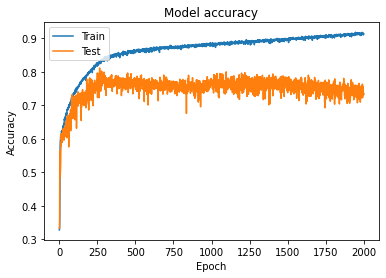

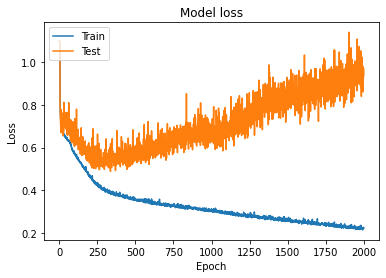

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig(output_main_path + save_plt_path + 'acc.png')
plt.show()
#plot_of_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig(output_main_path + save_plt_path + 'loss.png')
plt.show()